In [5]:
# takes ~20s to load all packages

# infrastructure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# profile and timer
import time
from tqdm import tqdm
import random
rd_seed = int(time.time()) % 317774
random.seed(rd_seed)
np.random.seed(rd_seed)
print("Random seed for random and np.random is:", rd_seed)

# different frameworks
import qiskit as qis
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector
#import cirq

# don't be scared by the warnings ("Please install....")
from QuICT.qcda.synthesis import QuantumStatePreparation
import QuICT as ict

from TDD.TDD_Q import gen_rand_circ
from tmp import *

Random seed for random and np.random is: 61540


## Global Parameters and Common Utils

In [19]:
T_weight = 0.1
to_test = False

def dump_mean_and_quantile(df, num_qubit: int, name: str, data: np.ndarray) -> None:
    df.loc[num_qubit, name] = np.mean(data)
    df.loc[num_qubit, name+'_q1'] = np.quantile(data, 0.25)
    df.loc[num_qubit, name+'_q3'] = np.quantile(data, 0.75)

def dump_four_attributes(df, num_qubit: int, runtime, gate_count, cx_count, depth, ) -> None:
    dump_mean_and_quantile(df, num_qubit, 'runtime', runtime)
    dump_mean_and_quantile(df, num_qubit, 'gate_count', gate_count)
    dump_mean_and_quantile(df, num_qubit, 'cx_count', cx_count)
    dump_mean_and_quantile(df, num_qubit, 'depth', depth)

## QuICT

In [20]:
def single_exp_quict(nr_qubit, nr_random_gates = None, rd_seed = None) -> dict:
    if nr_random_gates is None:
        nr_random_gates = 20*nr_qubit
    if rd_seed is not None:
        random.seed(rd_seed)
        np.random.seed(rd_seed)
    n = nr_qubit
    m = nr_random_gates

    rand_qc = gen_rand_circ('Random_Clifford_T', n, m, T_weight=T_weight)
    initial_state = Statevector.from_label('0'*n)
    desired_state = initial_state.evolve(rand_qc)

    QSP = QuantumStatePreparation('uniformly_gates')

    t1 = time.time()
    gates = QSP.execute(desired_state)
    t2 = time.time()

    qis_circ = qis.QuantumCircuit.from_qasm_str(gates.qasm())

    return {"runtime": t2-t1, "gate_count": len(qis_circ), "cx_count": qis_circ.count_ops()['cx'], "depth": qis_circ.depth()}

def single_exp_quict_wrapper(nr_qubit, nr_random_gates = None, rd_seed = None) -> None:
    while True:
        try:
            return single_exp_quict(nr_qubit, nr_random_gates, rd_seed)
            break
        except Exception as e: # QASMParseError
            print(e)
            continue

In [21]:
min_qubit = 2
max_qubit = 13

qubit_numbers = range(min_qubit, max_qubit+1)
df_quict = pd.DataFrame(index=qubit_numbers, columns=[
    "runtime", "runtime_q1", "runtime_q3",
    "gate_count", "gate_count_q1", "gate_count_q3",
    "cx_count", "cx_count_q1", "cx_count_q3",
    "depth", "depth_q1", "depth_q3"
])

for num_qubit in qubit_numbers: # #qubit=1 会有bug
    print('Qubit number:', num_qubit)
    num_attempts = 1000 // num_qubit**2
    runtime = np.zeros(num_attempts)
    gate_count = np.zeros(num_attempts)
    cx_count = np.zeros(num_attempts)
    depth = np.zeros(num_attempts)

    for i in tqdm(range(num_attempts)):
        res = single_exp_quict_wrapper(num_qubit)
        runtime[i] = res['runtime']
        gate_count[i] = res['gate_count']
        cx_count[i] = res['cx_count']
        depth[i] = res['depth']

    dump_four_attributes(df_quict, num_qubit, runtime, gate_count, cx_count, depth)

Qubit number: 2


  8%|▊         | 19/250 [00:00<00:01, 170.31it/s]c:\Users\lcj20\AppData\Local\Programs\Python\Python310\lib\site-packages\QuICT\qcda\synthesis\quantum_state_preparation\quantum_state_preparation.py:71: RuntimeWarning: invalid value encountered in arcsin
  alpha = np.where(np.isclose(denominator, 0), 0, 2 * np.arcsin(numerator[1::2] / denominator))
 38%|███▊      | 94/250 [00:00<00:00, 291.55it/s]

"<input>:5,3: 'nan' is not a parameter or custom instruction defined in this scope"


 50%|█████     | 125/250 [00:00<00:00, 297.75it/s]c:\Users\lcj20\AppData\Local\Programs\Python\Python310\lib\site-packages\QuICT\qcda\synthesis\quantum_state_preparation\quantum_state_preparation.py:71: RuntimeWarning: invalid value encountered in divide
  alpha = np.where(np.isclose(denominator, 0), 0, 2 * np.arcsin(numerator[1::2] / denominator))
100%|██████████| 250/250 [00:00<00:00, 307.43it/s]


Qubit number: 3


100%|██████████| 111/111 [00:00<00:00, 198.87it/s]


Qubit number: 4


100%|██████████| 62/62 [00:00<00:00, 131.72it/s]


Qubit number: 5


100%|██████████| 40/40 [00:00<00:00, 86.47it/s]


Qubit number: 6


 37%|███▋      | 10/27 [00:00<00:00, 49.97it/s]

"<input>:18,3: 'nan' is not a parameter or custom instruction defined in this scope"


 56%|█████▌    | 15/27 [00:00<00:00, 46.50it/s]

"<input>:18,3: 'nan' is not a parameter or custom instruction defined in this scope"


100%|██████████| 27/27 [00:00<00:00, 49.07it/s]


Qubit number: 7


100%|██████████| 20/20 [00:00<00:00, 27.28it/s]


Qubit number: 8


 53%|█████▎    | 8/15 [00:00<00:00, 12.69it/s]

"<input>:66,3: 'nan' is not a parameter or custom instruction defined in this scope"


100%|██████████| 15/15 [00:01<00:00, 14.07it/s]


Qubit number: 9


 42%|████▏     | 5/12 [00:00<00:01,  5.25it/s]

"<input>:130,3: 'nan' is not a parameter or custom instruction defined in this scope"


100%|██████████| 12/12 [00:01<00:00,  6.61it/s]


Qubit number: 10


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Qubit number: 11


100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


Qubit number: 12


100%|██████████| 6/6 [00:09<00:00,  1.59s/it]


Qubit number: 13


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


## Qiskit

In [22]:
def single_exp_qiskit(nr_qubit, nr_random_gates = None, rd_seed = None) -> dict:
    if nr_random_gates is None:
        nr_random_gates = 20*nr_qubit
    if rd_seed is not None:
        random.seed(rd_seed)
        np.random.seed(rd_seed)
    n = nr_qubit
    m = nr_random_gates

    rand_qc = gen_rand_circ('Random_Clifford_T', n, m, T_weight=T_weight)
    initial_state = Statevector.from_label('0'*n)
    desired_state = initial_state.evolve(rand_qc)

    stateprep = StatePreparation(desired_state)
    qc = QuantumCircuit(n)
    qc.append(stateprep, list(range(n)))

    t1 = time.time()
    qc_t = qis.transpile(qc, basis_gates=['cx','rx','ry','rz'])
    t2 = time.time()

    return {
        "runtime": t2-t1,
        "gate_count": len(qc_t),
        "cx_count": qc_t.count_ops().get('cx',0),
        "depth": qc_t.depth()
    }

In [23]:
min_qubit = 2
max_qubit = 13

qubit_numbers = range(min_qubit, max_qubit+1)
df_qiskit = pd.DataFrame(index=qubit_numbers, columns=[
    "runtime", "runtime_q1", "runtime_q3",
    "gate_count", "gate_count_q1", "gate_count_q3",
    "cx_count", "cx_count_q1", "cx_count_q3",
    "depth", "depth_q1", "depth_q3"
])

for num_qubit in qubit_numbers: # #qubit=1 会有bug
    print('Qubit number:', num_qubit)
    num_attempts = 1000 // num_qubit**2
    runtime = np.zeros(num_attempts)
    gate_count = np.zeros(num_attempts)
    cx_count = np.zeros(num_attempts)
    depth = np.zeros(num_attempts)

    for i in tqdm(range(num_attempts)):
        res = single_exp_qiskit(num_qubit)
        runtime[i] = res['runtime']
        gate_count[i] = res['gate_count']
        cx_count[i] = res['cx_count']
        depth[i] = res['depth']

    dump_four_attributes(df_qiskit, num_qubit, runtime, gate_count, cx_count, depth)

Qubit number: 2


100%|██████████| 250/250 [00:03<00:00, 78.91it/s]


Qubit number: 3


100%|██████████| 111/111 [00:01<00:00, 63.11it/s]


Qubit number: 4


100%|██████████| 62/62 [00:01<00:00, 49.25it/s]


Qubit number: 5


100%|██████████| 40/40 [00:01<00:00, 31.57it/s]


Qubit number: 6


100%|██████████| 27/27 [00:01<00:00, 22.69it/s]


Qubit number: 7


100%|██████████| 20/20 [00:01<00:00, 13.69it/s]


Qubit number: 8


100%|██████████| 15/15 [00:02<00:00,  7.47it/s]


Qubit number: 9


100%|██████████| 12/12 [00:03<00:00,  3.66it/s]


Qubit number: 10


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Qubit number: 11


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Qubit number: 12


100%|██████████| 6/6 [00:19<00:00,  3.30s/it]


Qubit number: 13


100%|██████████| 5/5 [00:54<00:00, 10.90s/it]


## LimTDD

### Mass Experiment

In [24]:
def single_exp_limtdd(nr_qubit, nr_random_gates = None, rd_seed = None, transpile = True) -> dict:
    if nr_random_gates is None:
        nr_random_gates = 20*nr_qubit
    if rd_seed is not None:
        random.seed(rd_seed)
        np.random.seed(rd_seed)
    n = nr_qubit
    m = nr_random_gates

    rand_cir=gen_rand_circ('Random_Clifford_T',n,m, T_weight=T_weight)
    tdd2=simulate(rand_cir,True,n)
    if tdd2.node.key!=n-1:
        raise Exception('Error')

    #! 这后面的profile是咋搞的？？？
    # if tdd2.node_number()>n+1:
    #     print('-')
    #print('-')
    #print(tdd2.node_number())
    #print('Doing state_pre...')
    t_start = time.time()
    tdd_2,cir_h2,cir_e2 = state_pre(tdd2)
    t_end = time.time()

    if transpile:
        cir_t = qis.transpile(cir_e2, basis_gates=['cp', 'p', 'unitary', 'x', 'cx', 'rx', 'ry', 'rz'], optimization_level=3)
    else:
        cir_t = cir_e2

    #print(cir_t.count_ops())
    return {
        "runtime": t_end-t_start,
        "gate_count": len(cir_t),
        "cx_count": sum(cir_t.count_ops().get(gate_type, 0) for gate_type in ['cx', 'cp', 'mcphase', 'c-unitary', 'ccx']),
        "depth": cir_t.depth()
    }

In [11]:
single_exp_limtdd(7, transpile=False)

{'runtime': 0.2975180149078369, 'gate_count': 79, 'cx_count': 49, 'depth': 51}

In [25]:
min_qubit = 2
max_qubit = 8

qubit_numbers = range(min_qubit, max_qubit+1)
df_limtdd_nt = pd.DataFrame(index=qubit_numbers, columns=[
    "runtime", "runtime_q1", "runtime_q3",
    "gate_count", "gate_count_q1", "gate_count_q3",
    "cx_count", "cx_count_q1", "cx_count_q3",
    "depth", "depth_q1", "depth_q3"
])

for num_qubit in qubit_numbers: # #qubit=1 会有bug
    print('Qubit number:', num_qubit)
    num_attempts = 1000 // num_qubit**2
    runtime = np.zeros(num_attempts)
    gate_count = np.zeros(num_attempts)
    cx_count = np.zeros(num_attempts)
    depth = np.zeros(num_attempts)

    for i in tqdm(range(num_attempts)):
        res = single_exp_limtdd(num_qubit, transpile=False)
        runtime[i] = res['runtime']
        gate_count[i] = res['gate_count']
        cx_count[i] = res['cx_count']
        depth[i] = res['depth']

    dump_four_attributes(df_limtdd_nt, num_qubit, runtime, gate_count, cx_count, depth)

Qubit number: 2


100%|██████████| 250/250 [00:04<00:00, 54.01it/s]


Qubit number: 3


100%|██████████| 111/111 [00:05<00:00, 21.87it/s]


Qubit number: 4


100%|██████████| 62/62 [00:06<00:00,  9.10it/s]


Qubit number: 5


100%|██████████| 40/40 [00:08<00:00,  4.51it/s]


Qubit number: 6


100%|██████████| 27/27 [00:11<00:00,  2.39it/s]


Qubit number: 7


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Qubit number: 8


100%|██████████| 15/15 [3:25:19<00:00, 821.31s/it]   


In [26]:
min_qubit = 2
max_qubit = 7

qubit_numbers = range(min_qubit, max_qubit+1)
df_limtdd_t = pd.DataFrame(index=qubit_numbers, columns=[
    "runtime", "runtime_q1", "runtime_q3",
    "gate_count", "gate_count_q1", "gate_count_q3",
    "cx_count", "cx_count_q1", "cx_count_q3",
    "depth", "depth_q1", "depth_q3"
])

for num_qubit in qubit_numbers: # #qubit=1 会有bug
    print('Qubit number:', num_qubit)
    num_attempts = 1000 // num_qubit**2
    runtime = np.zeros(num_attempts)
    gate_count = np.zeros(num_attempts)
    cx_count = np.zeros(num_attempts)
    depth = np.zeros(num_attempts)

    for i in tqdm(range(num_attempts)):
        res = single_exp_limtdd(num_qubit, transpile=True)
        runtime[i] = res['runtime']
        gate_count[i] = res['gate_count']
        cx_count[i] = res['cx_count']
        depth[i] = res['depth']


    dump_four_attributes(df_limtdd_t, num_qubit, runtime, gate_count, cx_count, depth)

Qubit number: 2


100%|██████████| 250/250 [00:08<00:00, 30.86it/s]


Qubit number: 3


100%|██████████| 111/111 [00:06<00:00, 16.12it/s]


Qubit number: 4


100%|██████████| 62/62 [00:08<00:00,  7.14it/s]


Qubit number: 5


100%|██████████| 40/40 [00:09<00:00,  4.16it/s]


Qubit number: 6


100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


Qubit number: 7


100%|██████████| 20/20 [35:06<00:00, 105.31s/it] 


(array([17.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([2.11656094e-02, 7.92375192e+01, 1.58453873e+02, 2.37670226e+02,
        3.16886580e+02, 3.96102934e+02, 4.75319287e+02, 5.54535641e+02,
        6.33751994e+02, 7.12968348e+02, 7.92184702e+02]),
 <BarContainer object of 10 artists>)

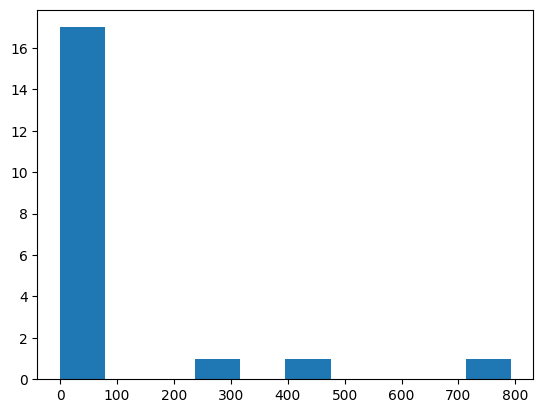

In [107]:
plt.hist(runtime)

## Plot

In [27]:
def custom_plot(df, attr: str, label=None, marker='s', color='C0', where_to_start_errbar=6, ):
    if where_to_start_errbar is not None:
        plt.errorbar(
            df.loc[where_to_start_errbar:].index,
            (df[attr+'_q1']+df[attr+'_q3']).loc[where_to_start_errbar:]/2,
            (df[attr+'_q3']-df[attr+'_q1']).loc[where_to_start_errbar:],
            color=color,
            linestyle='None',
            capsize=5
        )
    plt.plot(df.index, df[attr],
             marker=marker, markeredgecolor='k', markersize=4,
            label=label, color=color)

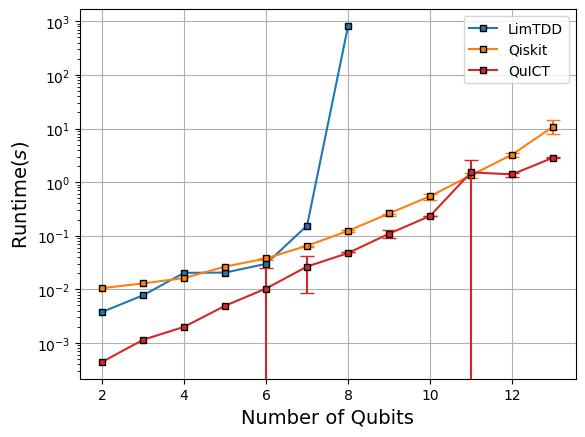

In [28]:
attribute = 'runtime'

plt.figure(figsize=(6.4, 4.8))

custom_plot(df_limtdd_nt, attribute, 'LimTDD', 's', 'C0', None)
custom_plot(df_qiskit, attribute, 'Qiskit', 's', 'C1', 6)
custom_plot(df_quict, attribute, 'QuICT', 's', 'C3', 6)

plt.yscale('log')
plt.xlabel('Number of Qubits', fontsize=14)
plt.ylabel('Runtime($s$)', fontsize=14)
plt.legend(); plt.grid()

plt.savefig('figure/runtime.jpg', dpi=400, bbox_inches='tight')

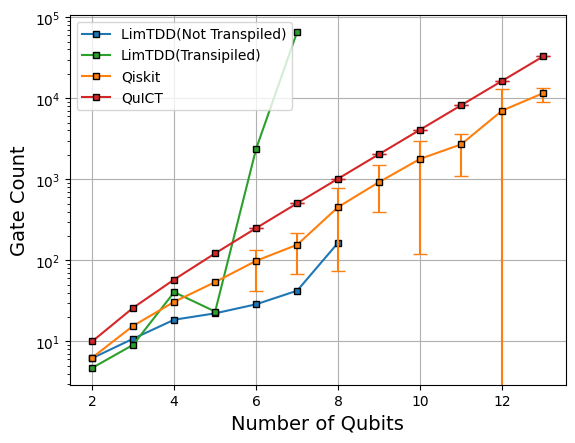

In [29]:
attribute = 'gate_count'

plt.figure(figsize=(6.4, 4.8))

custom_plot(df_limtdd_nt, attribute, 'LimTDD(Not Transpiled)', 's', 'C0', None)
custom_plot(df_limtdd_t, attribute, 'LimTDD(Transipiled)', 's', 'C2', None)
custom_plot(df_qiskit, attribute, 'Qiskit', 's', 'C1', 6)
custom_plot(df_quict, attribute, 'QuICT', 's', 'C3', 6)

plt.yscale('log')
plt.xlabel('Number of Qubits', fontsize=14)
plt.ylabel('Gate Count', fontsize=14)
plt.legend(); plt.grid()

plt.savefig('figure/gate_count.jpg', dpi=400, bbox_inches='tight')

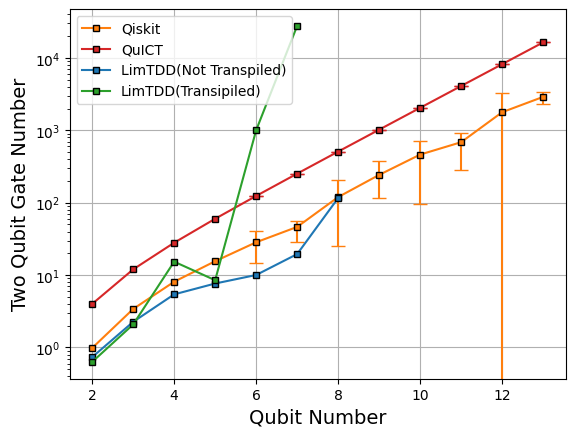

In [30]:
attribute = 'cx_count'

plt.figure(figsize=(6.4, 4.8))

custom_plot(df_qiskit, attribute, 'Qiskit', 's', 'C1', 6)
custom_plot(df_quict, attribute, 'QuICT', 's', 'C3', 6)
custom_plot(df_limtdd_nt, attribute, 'LimTDD(Not Transpiled)', 's', 'C0', None)
custom_plot(df_limtdd_t, attribute, 'LimTDD(Transipiled)', 's', 'C2', None)

plt.yscale('log')
plt.xlabel('Qubit Number', fontsize=14)
plt.ylabel('Two Qubit Gate Number', fontsize=14)
plt.legend(); plt.grid()

plt.savefig('figure/cx_count.jpg', dpi=400, bbox_inches='tight')

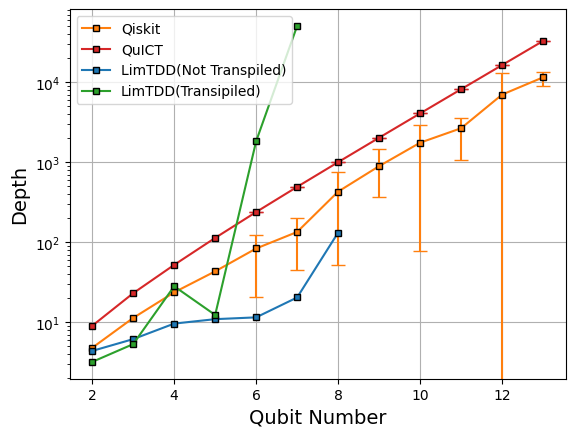

In [31]:
attribute = 'depth'

plt.figure(figsize=(6.4, 4.8))

custom_plot(df_qiskit, attribute, 'Qiskit', 's', 'C1', 6)
custom_plot(df_quict, attribute, 'QuICT', 's', 'C3', 6)
custom_plot(df_limtdd_nt, attribute, 'LimTDD(Not Transpiled)', 's', 'C0', None)
custom_plot(df_limtdd_t, attribute, 'LimTDD(Transipiled)', 's', 'C2', None)

plt.yscale('log')
plt.xlabel('Qubit Number', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.legend(); plt.grid()

plt.savefig('figure/depth.jpg', dpi=400, bbox_inches='tight')

## Cirq(x)

In [ ]:
import cirq
from cirq import CNOT, Rx, Ry, Rz  # NISQ 门集合

def nisq_state_preparation(state):
    """
    将给定量子态分解为 NISQ 门集合（CNOT + 单量子比特旋转门）的量子电路。
    """
    # 确定量子比特数
    num_qubits = int(np.log2(len(state)))

    # 创建量子比特
    qubits = cirq.LineQubit.range(num_qubits)

    # 创建量子电路
    circuit = cirq.Circuit()

    # 使用 Cirq 的 State Preparation 功能
    circuit.append(cirq.StatePreparationChannel(state).on(*qubits))

    # 将电路分解为 NISQ 门集合
    decomposed_circuit = cirq.optimize_for_target_gateset(
        circuit,
        gateset=cirq.Gateset(CNOT, rx, ry, rz)  # 目标门集合
    )

    return decomposed_circuit



In [16]:
state = np.array([1, 0])
print("Case 1: |0> state")
circuit = nisq_state_preparation(state)
print(circuit)

Case 1: |0> state


ValueError: Gate <function rx at 0x00000200A1E84940> must be an instance or subclass of `cirq.Gate`.

In [ ]:
# 示例使用
if __name__ == "__main__":
    # 示例1: 基础态 |0⟩
    state = np.array([1, 0])
    print("Case 1: |0> state")
    circuit = nisq_state_preparation(state)
    print(circuit)

    # 示例2: 叠加态 |+⟩
    state = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
    print("\nCase 2: |+> state")
    circuit = nisq_state_preparation(state)
    print(circuit)

    # 示例3: 任意态 (例如 [0.6, 0.8i])
    state = np.array([0.6, 0.8j])
    print("\nCase 3: Arbitrary state [0.6, 0.8i]")
    circuit = nisq_state_preparation(state)
    print(circuit)

In [ ]:
# 确定量子比特数
num_qubits = int(np.log2(len(state)))

# 创建量子比特
qubits = cirq.LineQubit.range(num_qubits)

# 创建量子电路
circuit = cirq.Circuit()

# 使用 Cirq 的 State Preparation 功能
circuit.append(cirq.StatePreparationChannel(state).on(*qubits))

# 将电路分解为 NISQ 门集合
decomposed_circuit = cirq.optimize_for_target_gateset(
    circuit,
    gateset=cirq.Gateset(CNOT, Rx, Ry, Rz)  # 目标门集合
)

decomposed_circuit

AttributeError: 'Gateset' object has no attribute 'preprocess_transformers'